# 0. Imports

In [1]:
! pip install torchsummary

In [2]:
# imports

import torch
from torch import nn
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
from torchsummary import summary
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, RMSprop, SGD
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [3]:
# for reproducibility
torch.manual_seed(42)

In [4]:
# setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda')

# 1. Dataset and Dataloader

In [5]:
# data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         transforms.RandomHorizontalFlip(), 
                         transforms.ToTensor(), 
                         transforms.Normalize(*stats,inplace=True)])
valid_tfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*stats)])

In [6]:
# get cifar10
train_dataset = CIFAR10(root='data', transform=train_tfms, download=True, train=True)
val_dataset = CIFAR10(root='data', transform=valid_tfms, download=True, train=False)
len(train_dataset), len(val_dataset)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

In [7]:
# create dataloaders
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# 2. Create a CNN

In [8]:
class CifarClassifier(nn.Module):
    
    def __init__(self, activation: str):
        super().__init__()
        assert activation in ["relu", "sigmoid", "tanh"] , "select activation from relu, sigmoid, tanh"
        
        self.activation_layer = None
        if activation == "relu":
            self.activation_layer = nn.ReLU()
        elif activation == "sigmoid":
            self.activation_layer = nn.Sigmoid()
        elif activation == "tanh":
            self.activation_layer = nn.Tanh()
            
        self.model = nn.Sequential(
            
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same"),
            self.activation_layer, 
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Dropout(0.16),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same"),
            self.activation_layer, 
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Dropout(0.16),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same"),
            self.activation_layer, 
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout(0.16),

            
            
            
            nn.Flatten(),
            nn.Linear(in_features=2048, out_features=256),
            self.activation_layer,
            nn.Linear(in_features=256, out_features=10)
        )
        
    def forward(self, x):
        return self.model(x)

In [9]:
model = CifarClassifier("relu").to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
              ReLU-3           [-1, 32, 32, 32]               0
       BatchNorm2d-4           [-1, 32, 32, 32]              64
         MaxPool2d-5           [-1, 32, 16, 16]               0
           Dropout-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          18,496
              ReLU-8           [-1, 64, 16, 16]               0
              ReLU-9           [-1, 64, 16, 16]               0
      BatchNorm2d-10           [-1, 64, 16, 16]             128
        MaxPool2d-11             [-1, 64, 8, 8]               0
          Dropout-12             [-1, 64, 8, 8]               0
           Conv2d-13            [-1, 128, 8, 8]          73,856
             ReLU-14            [-1, 12

# 3. Training Loop

In [10]:
# create loss_fn
loss_fn = CrossEntropyLoss()

In [11]:
# create optimizer

lr = 1.6 * (10**-3)
optimizer = Adam(model.parameters(), lr=lr)

In [12]:
abl_lis = []

In [13]:
# run the training loop
from utils import train_step

# running for less epochs as we generalize later
epochs = 4
for epoch in tqdm(range(epochs)):
        tres = train_step(model, train_dataloader, loss_fn, optimizer, device)
        print(f"epoch: {epoch}")
        print(f"avg_batch_loss: {tres['avg_batch_loss']}")
        print(f"time: {tres['time']}")   
        print("")
        abl_lis.append(tres['avg_batch_loss'].item())

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 0
avg_batch_loss: 1.443744421005249
time: 30423.949003219604

epoch: 1
avg_batch_loss: 1.034765362739563
time: 28727.20241546631

epoch: 2
avg_batch_loss: 0.8970182538032532
time: 29179.116249084473

epoch: 3
avg_batch_loss: 0.8197057843208313
time: 29338.217973709106



In [14]:
# validation
from utils import valid_step

vres = valid_step(model, val_dataloader, device)
print(f"accuracy: {vres['accuracy']}")
print(f"confusion_matrix: \n{vres['confusion_matrix']}")

accuracy: 0.7648
confusion_matrix: 
[[0.804 0.032 0.023 0.019 0.014 0.002 0.01  0.017 0.057 0.022]
 [0.007 0.932 0.002 0.004 0.    0.002 0.003 0.005 0.015 0.03 ]
 [0.075 0.006 0.564 0.056 0.095 0.037 0.09  0.058 0.011 0.008]
 [0.013 0.006 0.047 0.608 0.052 0.125 0.068 0.061 0.012 0.008]
 [0.012 0.003 0.04  0.04  0.745 0.015 0.049 0.084 0.01  0.002]
 [0.005 0.005 0.032 0.178 0.052 0.622 0.02  0.076 0.006 0.004]
 [0.006 0.01  0.022 0.044 0.033 0.009 0.865 0.006 0.004 0.001]
 [0.011 0.005 0.013 0.025 0.036 0.031 0.004 0.871 0.002 0.002]
 [0.048 0.033 0.003 0.009 0.004 0.    0.003 0.009 0.884 0.007]
 [0.021 0.138 0.008 0.007 0.002 0.003 0.008 0.021 0.039 0.753]]


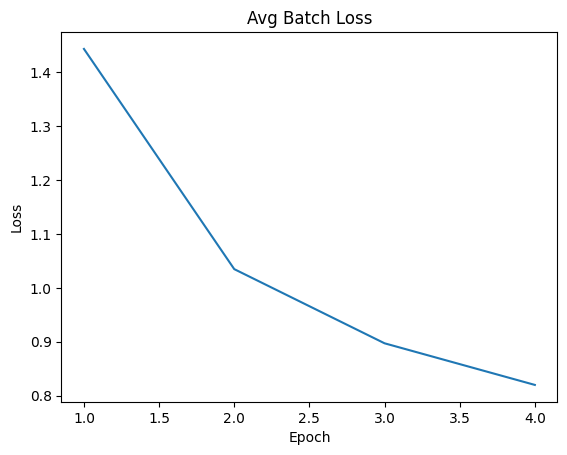

In [15]:
# avg batch loss line chart
fig, ax = plt.subplots()
ax.plot([i+1 for i in range(len(abl_lis))], abl_lis)
# Set labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Avg Batch Loss')
fig.savefig("relu_adam.jpg")

# 4. Generalize for All Results

In [16]:
# generalize optimizers
opt_lis = ["adam", "rms", "sgd"]

def get_optimizer(model, opt_type):
    if(opt_type == "adam"):
        return Adam(model.parameters(), 1.6 * (10**-3))
    elif(opt_type == "rms"):
        return RMSprop(model.parameters(), 1.6 * (10**-3))
    elif(opt_type == "sgd"):
        return SGD(model.parameters(), 1.6 * (10**-3))

In [17]:
import os
os.makedirs("avg_batch_loss", exist_ok=True)
os.makedirs("training_results", exist_ok=True)

In [18]:
act_lis = ["relu", "tanh", "sigmoid"]

In [19]:
# build generalized function

def generalize(opt_type, act_type):
    model = CifarClassifier(activation=act_type).to(device)
    loss_fn = CrossEntropyLoss()
    optimizer = get_optimizer(model, opt_type)
    epochs = 32
    file_str = ""
    abl_lis = []
    for epoch in tqdm(range(epochs)):
        tres = train_step(model, train_dataloader, loss_fn, optimizer, device)
        print(f"epoch: {epoch}")
        print(f"avg_batch_loss: {tres['avg_batch_loss']}")
        print(f"time: {tres['time']}")   
        print("")
        file_str += f"epoch: {epoch}\n"
        file_str += f"avg_batch_loss: {tres['avg_batch_loss']}\n"
        file_str += f"time: {tres['time']}\n\n"
        abl_lis.append(tres['avg_batch_loss'].item())

    # avg batch loss line chart
    fig, ax = plt.subplots()
    ax.plot([i+1 for i in range(len(abl_lis))], abl_lis)
    # Set labels and title
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Avg Batch Loss')
    fig.savefig(f"avg_batch_loss/{opt_type}_{act_type}.jpg")
    
    vres = valid_step(model, val_dataloader, device)
    print(f"accuracy: {vres['accuracy']}")
    print(f"confusion_matrix: \n{vres['confusion_matrix']}")
    file_str += f"accuracy: {vres['accuracy']}\n"
    file_str += f"confusion_matrix: \n{vres['confusion_matrix']}\n"
    
    with open(f"training_results/{opt_type}_{act_type}.txt", "w") as f:
        f.write(file_str)




In [20]:
# generalize("adam", "relu")

  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 0
avg_batch_loss: 1.4170501232147217
time: 29208.438873291016

epoch: 1
avg_batch_loss: 1.0345189571380615
time: 29098.84214401245

epoch: 2
avg_batch_loss: 0.9057539701461792
time: 29393.131494522095

epoch: 3
avg_batch_loss: 0.8315849900245667
time: 29278.54895591736

epoch: 4
avg_batch_loss: 0.7789484262466431
time: 29476.11379623413

epoch: 5
avg_batch_loss: 0.7364447116851807
time: 29523.573398590088

epoch: 6
avg_batch_loss: 0.7047951221466064
time: 29222.82099723816

epoch: 7
avg_batch_loss: 0.6784568428993225
time: 29701.59339904785

epoch: 8
avg_batch_loss: 0.6548236608505249
time: 29365.07511138916

epoch: 9
avg_batch_loss: 0.6342136859893799
time: 29105.143070220947

epoch: 10
avg_batch_loss: 0.6205658316612244
time: 29600.661277770996

epoch: 11
avg_batch_loss: 0.6004178524017334
time: 29245.707750320435

epoch: 12
avg_batch_loss: 0.5860253572463989
time: 29235.55564880371

epoch: 13
avg_batch_loss: 0.5733394622802734
time: 29470.996141433716

epoch: 14
avg_batch_los

  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 0
avg_batch_loss: 1.6187052726745605
time: 29294.5077419281

epoch: 1
avg_batch_loss: 1.232954502105713
time: 29178.170442581177

epoch: 2
avg_batch_loss: 1.0949169397354126
time: 29619.01021003723

epoch: 3
avg_batch_loss: 1.0242054462432861
time: 29699.17345046997

epoch: 4
avg_batch_loss: 0.9827404022216797
time: 29814.170837402344

epoch: 5
avg_batch_loss: 0.941202700138092
time: 29444.939851760864

epoch: 6
avg_batch_loss: 0.9211464524269104
time: 29739.078044891357

epoch: 7
avg_batch_loss: 0.8926583528518677
time: 29333.836555480957

epoch: 8
avg_batch_loss: 0.8775890469551086
time: 29583.41383934021

epoch: 9
avg_batch_loss: 0.8569806218147278
time: 29434.28111076355

epoch: 10
avg_batch_loss: 0.8513715267181396
time: 29591.24803543091

epoch: 11
avg_batch_loss: 0.8375126123428345
time: 29388.277053833008

epoch: 12
avg_batch_loss: 0.8249276280403137
time: 29764.321327209473

epoch: 13
avg_batch_loss: 0.8100705742835999
time: 29501.811027526855

epoch: 14
avg_batch_loss:

  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 0
avg_batch_loss: 1.5375330448150635
time: 30504.537343978882

epoch: 1
avg_batch_loss: 1.1713894605636597
time: 30885.556936264038

epoch: 2
avg_batch_loss: 1.0431228876113892
time: 32927.86693572998

epoch: 3
avg_batch_loss: 0.9617164731025696
time: 29896.663665771484

epoch: 4
avg_batch_loss: 0.9058827757835388
time: 29606.77480697632

epoch: 5
avg_batch_loss: 0.8629529476165771
time: 29160.334587097168

epoch: 6
avg_batch_loss: 0.8303927779197693
time: 29538.079977035522

epoch: 7
avg_batch_loss: 0.8004897832870483
time: 29191.933631896973

epoch: 8
avg_batch_loss: 0.7772793769836426
time: 29658.81657600403

epoch: 9
avg_batch_loss: 0.7601827383041382
time: 31415.974378585815

epoch: 10
avg_batch_loss: 0.7376135587692261
time: 31358.879566192627

epoch: 11
avg_batch_loss: 0.7257634997367859
time: 30728.818893432617

epoch: 12
avg_batch_loss: 0.7141942381858826
time: 30876.85513496399

epoch: 13
avg_batch_loss: 0.7005677223205566
time: 30540.67635536194

epoch: 14
avg_batch_l

  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 0
avg_batch_loss: 1.8884029388427734
time: 30620.667934417725

epoch: 1
avg_batch_loss: 1.237065076828003
time: 29809.903383255005

epoch: 2
avg_batch_loss: 1.0754796266555786
time: 30520.357370376587

epoch: 3
avg_batch_loss: 0.9509358406066895
time: 29998.693704605103

epoch: 4
avg_batch_loss: 0.8693893551826477
time: 30108.381271362305

epoch: 5
avg_batch_loss: 0.8140872716903687
time: 30106.96792602539

epoch: 6
avg_batch_loss: 0.767151951789856
time: 30501.35588645935

epoch: 7
avg_batch_loss: 0.7308075428009033
time: 30229.342460632324

epoch: 8
avg_batch_loss: 0.6997925043106079
time: 30572.758674621582

epoch: 9
avg_batch_loss: 0.6762551069259644
time: 29774.571180343628

epoch: 10
avg_batch_loss: 0.6516757607460022
time: 30238.841772079468

epoch: 11
avg_batch_loss: 0.6314333081245422
time: 29935.555934906006

epoch: 12
avg_batch_loss: 0.6159844994544983
time: 30353.11245918274

epoch: 13
avg_batch_loss: 0.6023175716400146
time: 29681.992053985596

epoch: 14
avg_batch_l

  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 0
avg_batch_loss: 1.679792046546936
time: 30500.96082687378

epoch: 1
avg_batch_loss: 1.3258864879608154
time: 29921.563625335693

epoch: 2
avg_batch_loss: 1.200456142425537
time: 30136.144161224365

epoch: 3
avg_batch_loss: 1.1279462575912476
time: 29716.330766677856

epoch: 4
avg_batch_loss: 1.0759044885635376
time: 30120.288372039795

epoch: 5
avg_batch_loss: 1.0406602621078491
time: 29646.348237991333

epoch: 6
avg_batch_loss: 1.0090429782867432
time: 30332.747220993042

epoch: 7
avg_batch_loss: 0.9825044274330139
time: 29795.867204666138

epoch: 8
avg_batch_loss: 0.9601743817329407
time: 30027.371168136597

epoch: 9
avg_batch_loss: 0.9368157982826233
time: 30041.08762741089

epoch: 10
avg_batch_loss: 0.9306372404098511
time: 30160.49599647522

epoch: 11
avg_batch_loss: 0.9111244082450867
time: 29999.5174407959

epoch: 12
avg_batch_loss: 0.8952288031578064
time: 29971.460342407227

epoch: 13
avg_batch_loss: 0.8764967322349548
time: 29208.68158340454

epoch: 14
avg_batch_loss

  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 0
avg_batch_loss: 1.6381371021270752
time: 29648.253202438354

epoch: 1
avg_batch_loss: 1.281957745552063
time: 29055.499792099

epoch: 2
avg_batch_loss: 1.148432970046997
time: 29591.44639968872

epoch: 3
avg_batch_loss: 1.0631238222122192
time: 29450.61492919922

epoch: 4
avg_batch_loss: 1.0035239458084106
time: 29334.115982055664

epoch: 5
avg_batch_loss: 0.9510897994041443
time: 29168.576955795288

epoch: 6
avg_batch_loss: 0.91013103723526
time: 29470.733165740967

epoch: 7
avg_batch_loss: 0.8752180337905884
time: 29314.842224121094

epoch: 8
avg_batch_loss: 0.8560492396354675
time: 29215.295553207397

epoch: 9
avg_batch_loss: 0.8251793384552002
time: 29336.230754852295

epoch: 10
avg_batch_loss: 0.8043954372406006
time: 29394.778966903687

epoch: 11
avg_batch_loss: 0.7930562496185303
time: 29370.795011520386

epoch: 12
avg_batch_loss: 0.7743454575538635
time: 29184.58867073059

epoch: 13
avg_batch_loss: 0.7615923881530762
time: 29451.273441314697

epoch: 14
avg_batch_loss: 

  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 0
avg_batch_loss: 2.11641526222229
time: 30192.232847213745

epoch: 1
avg_batch_loss: 1.8745841979980469
time: 29553.208589553833

epoch: 2
avg_batch_loss: 1.7534565925598145
time: 29164.07585144043

epoch: 3
avg_batch_loss: 1.6709083318710327
time: 30181.586503982544

epoch: 4
avg_batch_loss: 1.6002917289733887
time: 32116.06240272522

epoch: 5
avg_batch_loss: 1.550681471824646
time: 32395.052671432495

epoch: 6
avg_batch_loss: 1.50987708568573
time: 32299.270153045654

epoch: 7
avg_batch_loss: 1.4767343997955322
time: 31853.934288024902

epoch: 8
avg_batch_loss: 1.4503775835037231
time: 31250.269174575806

epoch: 9
avg_batch_loss: 1.4246045351028442
time: 30108.126163482666

epoch: 10
avg_batch_loss: 1.4038461446762085
time: 29909.867763519287

epoch: 11
avg_batch_loss: 1.378569483757019
time: 31061.22374534607

epoch: 12
avg_batch_loss: 1.3588409423828125
time: 30227.94246673584

epoch: 13
avg_batch_loss: 1.3365341424942017
time: 30582.980155944824

epoch: 14
avg_batch_loss: 

  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 0
avg_batch_loss: 2.1596920490264893
time: 29755.147695541382

epoch: 1
avg_batch_loss: 1.971936583518982
time: 29781.02135658264

epoch: 2
avg_batch_loss: 1.877884864807129
time: 29842.91696548462

epoch: 3
avg_batch_loss: 1.8214995861053467
time: 29791.279315948486

epoch: 4
avg_batch_loss: 1.7785108089447021
time: 29785.93635559082

epoch: 5
avg_batch_loss: 1.7411912679672241
time: 29405.30252456665

epoch: 6
avg_batch_loss: 1.7127869129180908
time: 29339.10846710205

epoch: 7
avg_batch_loss: 1.6836823225021362
time: 29741.418600082397

epoch: 8
avg_batch_loss: 1.6545634269714355
time: 29385.929822921753

epoch: 9
avg_batch_loss: 1.627910852432251
time: 29508.47029685974

epoch: 10
avg_batch_loss: 1.598931908607483
time: 29336.695671081543

epoch: 11
avg_batch_loss: 1.5703420639038086
time: 29498.947381973267

epoch: 12
avg_batch_loss: 1.5467350482940674
time: 29730.13949394226

epoch: 13
avg_batch_loss: 1.5226445198059082
time: 29613.293647766113

epoch: 14
avg_batch_loss: 1

  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 0
avg_batch_loss: 2.2871134281158447
time: 30040.89045524597

epoch: 1
avg_batch_loss: 2.227522611618042
time: 29403.66816520691

epoch: 2
avg_batch_loss: 2.1711347103118896
time: 29826.87282562256

epoch: 3
avg_batch_loss: 2.115173816680908
time: 29611.509084701538

epoch: 4
avg_batch_loss: 2.0640833377838135
time: 29608.49142074585

epoch: 5
avg_batch_loss: 2.0236713886260986
time: 29641.902923583984

epoch: 6
avg_batch_loss: 1.9889668226242065
time: 29514.119148254395

epoch: 7
avg_batch_loss: 1.958263635635376
time: 29848.48427772522

epoch: 8
avg_batch_loss: 1.9338384866714478
time: 29491.258144378662

epoch: 9
avg_batch_loss: 1.909588098526001
time: 29548.78282546997

epoch: 10
avg_batch_loss: 1.890820860862732
time: 29622.508764266968

epoch: 11
avg_batch_loss: 1.8732304573059082
time: 29570.07098197937

epoch: 12
avg_batch_loss: 1.8560903072357178
time: 29300.76289176941

epoch: 13
avg_batch_loss: 1.8439865112304688
time: 29563.963651657104

epoch: 14
avg_batch_loss: 1.8

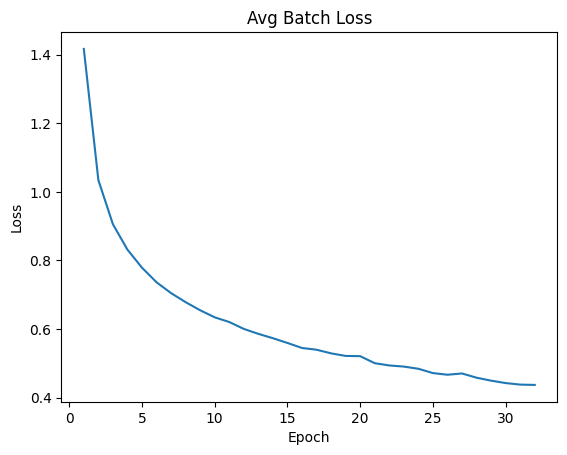

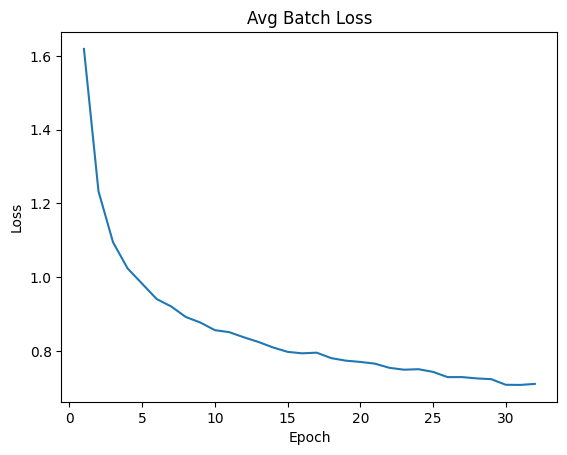

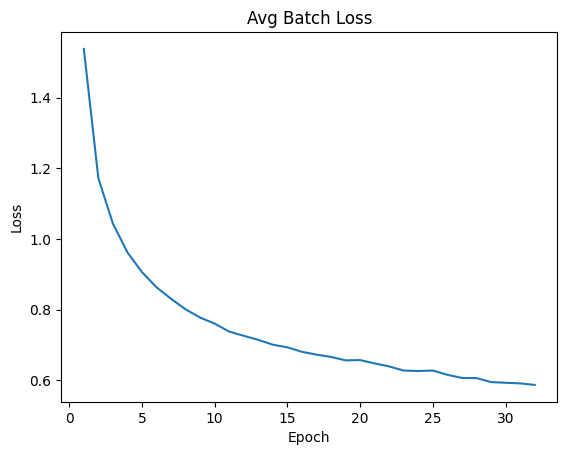

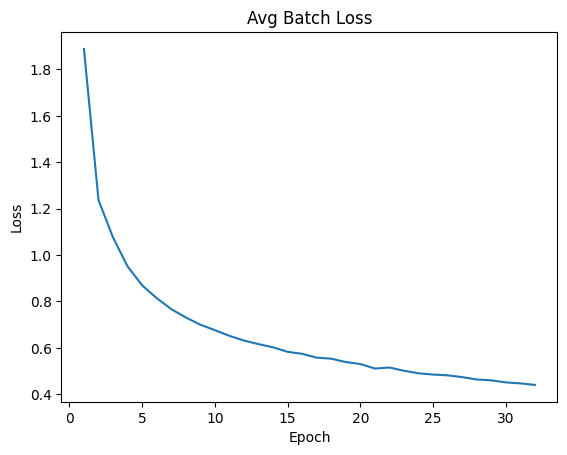

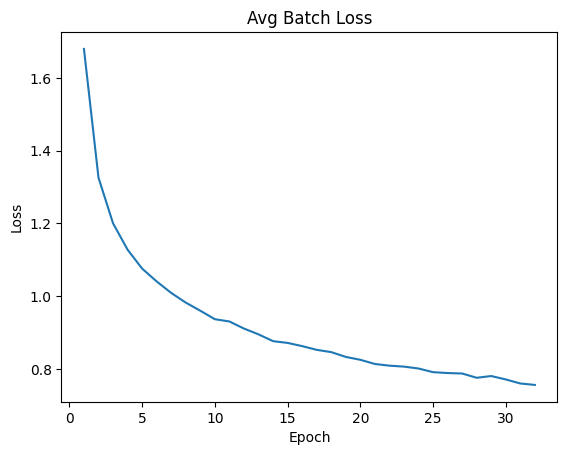

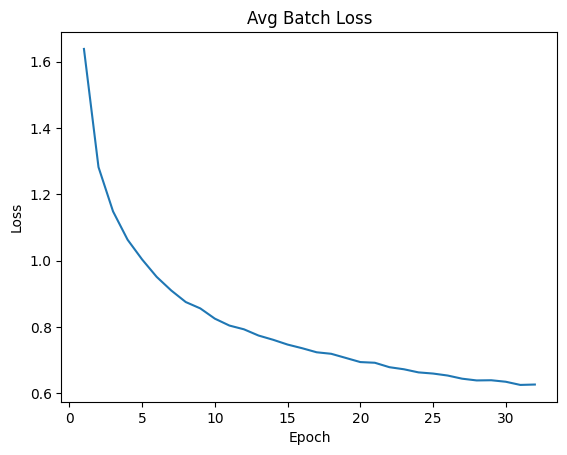

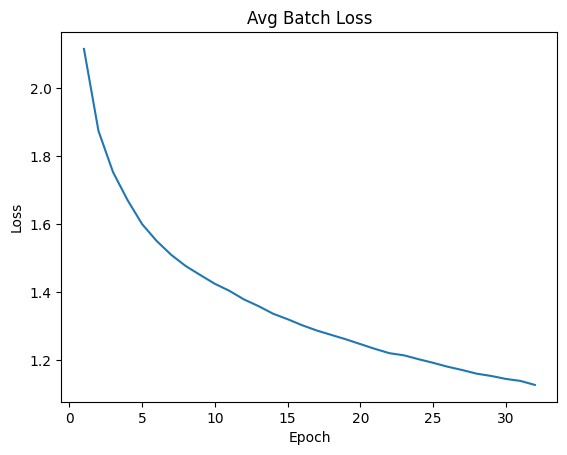

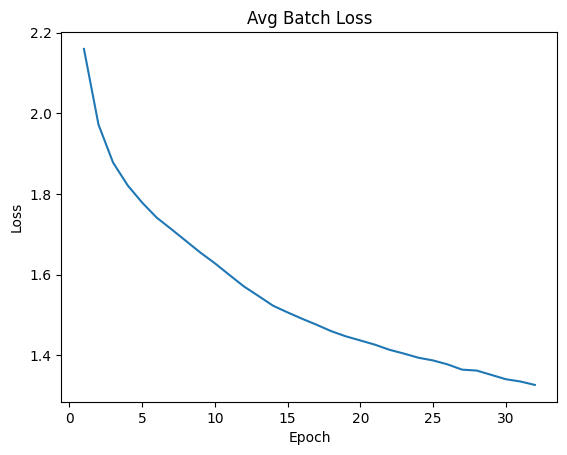

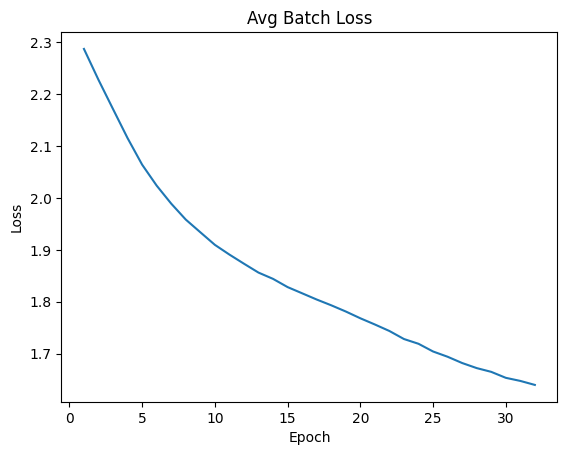

In [21]:
for opt_type in opt_lis:
    for act_type in act_lis:
        generalize(opt_type, act_type)

In [33]:
! zip -r all_files.zip *

  adding: __pycache__/ (stored 0%)
  adding: __pycache__/utils.cpython-310.pyc (deflated 36%)
  adding: avg_batch_loss/ (stored 0%)
  adding: avg_batch_loss/sgd_tanh.jpg (deflated 43%)
  adding: avg_batch_loss/rms_sigmoid.jpg (deflated 43%)
  adding: avg_batch_loss/rms_tanh.jpg (deflated 44%)
  adding: avg_batch_loss/adam_sigmoid.jpg (deflated 44%)
  adding: avg_batch_loss/sgd_relu.jpg (deflated 44%)
  adding: avg_batch_loss/adam_tanh.jpg (deflated 44%)
  adding: avg_batch_loss/sgd_sigmoid.jpg (deflated 41%)
  adding: avg_batch_loss/adam_relu.jpg (deflated 43%)
  adding: avg_batch_loss/rms_relu.jpg (deflated 42%)
  adding: data/ (stored 0%)
  adding: data/cifar-10-python.tar.gz (deflated 0%)
  adding: data/cifar-10-batches-py/ (stored 0%)
  adding: data/cifar-10-batches-py/batches.meta (deflated 12%)
  adding: data/cifar-10-batches-py/data_batch_3 (deflated 8%)
  adding: data/cifar-10-batches-py/data_batch_2 (deflated 8%)
  adding: data/cifar-10-batches-py/test_batch (deflated 8%)
  ad

In [34]:
from IPython.display import FileLink
FileLink(r'all_files.zip')

/kaggle/working/all_files.zip